This tutorial is an introduction to BigQuery ML. It is based
on the [official documentation tutorial](https://cloud.google.com/bigquery/docs/bigqueryml-scientist-start). In this tutorial, you use the sample
[Google Analytics sample dataset for BigQuery](https://support.google.com/analytics/answer/7586738?hl=en&ref_topic=3416089) to create a model that predicts whether a website visitor will make a transaction. For information on the schema of the Analytics dataset, see [BigQuery export schema](https://support.google.com/analytics/answer/3437719).


There is also an accopmnying livestream video, [which can be found here](https://youtu.be/a1onYwwFqj0) and [a notebook with exercises for you to try out](https://www.kaggle.com/rtatman/bigquery-machine-learning-exercise). 

## What is BigQuery ML and when should you use it?

BigQuery Machine Learning (BQML) is a toolset that allows you to train and serve machine learning models directly in BigQuery. This has several advantages: 

* **You don't have to read your data into local memory.** One question I get a lot is "how can I train my ML model if my dataset is just too big to fit on my computer?". You can subsample your dataset, of course, but you can also use tools like BQML that train your model directly in your database.
* **You don't have to use multiple languages.** Particularly if you're working in a team where most of your teammates don't know  Python or R or your preferred language for modelling, working in SQL can make it easier for you to collaborate.
* **You can serve your model immediately after it's trained.** Because your model is already in the same place as your data, you can make predictions directly from your database. This lets you get around the hassle of cleaning up your code and either putting it intro production or passing it off to your engineering colleagues.

BQML probably won't replace all your modelling tools, but it's a nice quick way to train and serve a model without spending a lot of time moving code or data around. 

### Models supported by BQML

One limitation of BQML is that a limited number of model types are supported. As of August 6, 2019, [BQML supports the following types of models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#model_type). More model types are being built out, though, so check the documentation for the most

* Linear regression (LINEAR_REG). This is the OG modelling technique, used to predict the value of a continuous variable. This is what you'd use for questions like "how many units can we expect a custom to buy?". 
* Logistic regression (LOGISTIC_REG). This regression technique lets you classify which category an observation fits in to. For example, "will this person buy the blue one or the red one?". 
* K-means (KMEANS). This is an unsupervised clustering algorithm. It lets you identify categories. For example, "given all of the customers in our database, how could we identify five distinct groups?".
* Tensorflow (TENSORFLOW). If you've already got a trained TensorFlow model, you can upload it to BQML and serve it directly from there. You can't currently train a TensorFlow model in BQML.

> If you need a quick regression refresher, check out the [5-Day Regression Challenge notebooks](https://www.kaggle.com/rtatman/the-5-day-regression-challenge). It's in R but don't worry if you're a Pythonista, I walk you through all the code. :)

Assuming that at least of those model types fits your use case, then BQML might be the right choice for you! Let's get started building our first model.



## Objectives

In this tutorial, you will use:

+ BQML to create a binary logistic regression model using the
  `CREATE MODEL` statement
+ The `ML.EVALUATE` function to evaluate the ML model
+ The `ML.PREDICT` function to make predictions using the ML model

## Step one: Setup and create your dataset

First, you'll need to create a BigQuery dataset to store your
ML model. You don't actually have to upload any data; the only table in it will be the one with your trained model.

> If you're curious about the client and what it does, check out [the first lesson in the Intro SQL course](https://www.kaggle.com/dansbecker/getting-started-with-sql-and-bigquery) and [the accompying video](https://www.youtube.com/watch?v=jYQoQfFzJRw&list=PLqFaTIg4myu9neIs_wfWzgeOkKbiImXB6&index=2&t=0s).)

In [1]:
# Set your own project id here
PROJECT_ID = 'kaggle-bqml-249200'

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, location="US")
dataset = client.create_dataset('bqml_tutorial', exists_ok=True)

from google.cloud.bigquery import magics
from kaggle.gcp import KaggleKernelCredentials
magics.context.credentials = KaggleKernelCredentials()
magics.context.project = PROJECT_ID


For this example, we will use the Google Analytics sample
dataset to predict whether a website visitor will make a transaction. First, let's take a quick look at the data we'll be using. 

In [2]:
# create a reference to our table
table = client.get_table("bigquery-public-data.google_analytics_sample.ga_sessions_*")

# look at five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,None,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,None,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,None,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged
3,None,1,1501573386,1501573386,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",0750846065342433129,None,None,Direct,Not Socially Engaged
4,None,8,1501651467,1501651467,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",0573427169410921198,None,None,Organic Search,Not Socially Engaged


This table looks a little different from some of the ones you've seen in the Intro to SQL course. Notably the columns for "totals", "trafficSource", "device", "geoNetwork", "customDimensions" and "hits" are of a new data type called [STRUCT (or RECORD) which is used for nested data structures](https://cloud.google.com/bigquery/docs/nested-repeated). We'll learn more about these in the advanced SQL course, but for now all you need to know is:

1. Each cell in a specific column has the same fields in it. (These are specified in the schema.)
2. You can get the information from a specific field for a whole column using the syntax COLUMN_NAME.FIELD_NAME.

So for the "totals" column, we could get the "transactions" field by using the syntax `totals.transactions`. (You can see all the fields in a record from the "totals" column below). 

In [3]:
# create a small sample dataframe
sample_table = client.list_rows(table, max_results=5).to_dataframe()

# get the first cell in the "totals" column
sample_table.totals[0]

{'visits': 1,
 'hits': 1,
 'pageviews': 1,
 'timeOnSite': None,
 'bounces': 1,
 'transactions': None,
 'transactionRevenue': None,
 'newVisits': 1,
 'screenviews': None,
 'uniqueScreenviews': None,
 'timeOnScreen': None,
 'totalTransactionRevenue': None,
 'sessionQualityDim': 1}

For this problem, we'll be trying to predict transactions from the totals column, so keep this in mind! :)

## Step two: Create your model

Next, we will create a logistic regression model for classification. 

The standard SQL query uses a `CREATE MODEL` statement to create and train the model. You can [find the documentation for this fuction here](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#model_type). 

The BigQuery Python client library provides a custom magic command so that you don't need to set up the queries yourself. To load the magic commands from the
client library, run the following code.

> If you prefer not to use the magic command, you can use client-based way of writing queries covered in the [Intro to SQL course](https://www.kaggle.com/dansbecker/getting-started-with-sql-and-bigquery). They'll both work the same, it's just a slightly different style of writing code. :)

In [4]:
%load_ext google.cloud.bigquery

> `%load_ext` is one of the many Jupyter built-in magic commands. See the
[Jupyter documentation](https://ipython.readthedocs.io/en/stable/interactive/magics.html) for more
information about `%load_ext` and other magic commands.

The BigQuery client library provides a cell magic,
`%%bigquery`, which runs a SQL query and returns the results as a Pandas
DataFrame. Once you use this command the rest of your cell will be treated as a SQL command. (Note that tab complete won't work for SQL code written in this way.)

Here's the the query that will train our model:

In [5]:
%%bigquery
CREATE MODEL IF NOT EXISTS `bqml_tutorial.sample_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170630'

Executing query with job ID: e240865d-9ab4-4dd1-bde8-cfb31480a564
Query executing: 8.21s

BadRequest: 400 GET https://www.googleapis.com/bigquery/v2/projects/kaggle-bqml-249200/queries/e240865d-9ab4-4dd1-bde8-cfb31480a564?maxResults=0&timeoutMs=0&location=US: The job encountered an internal error during execution and was unable to complete successfully.

Let's break down this command a little bit. This is a fairly fancy query, which is nice because it lets you see a lot of the options you have when using BQML.

This line is writing our model to BigQuery. (The fact that BQML requires write permissions is why you needed to set up your GCP account; the default Kaggle connection doesn't allow you write tables, only query them. 

    %%bigquery
    CREATE MODEL IF NOT EXISTS `bqml_tutorial.sample_model`
    
Here we're specifying that our model will be logistic regression, so we know it's a classification task. Next we need to actually define our model.

    OPTIONS(model_type='logistic_reg') AS
    
The code under the SELECT clause is where we define the variable we're trying to predict as well as what variables we want to use to predict it.

The column we alias as "label" will be our dependent variable, the thing we're trying to predict. The `IF(totals.transactions IS NULL, 0, 1)` bit just means that if the values of the transactions field is NULL or None, we'll assign it a value of "0", otherwise it will have a value of one. Since we have two labels, BQML will automatically use binary regression for us.

The other four rows say what information we want to use to predict that label. Here we're information on the device operating system, whether it's a mobile device, the country and the number of pageviews. For the os, country and pageviews, we're assigning appropriate values to null fields. Either making them blank (so we're not saying people are from NULL country!) or setting them to 0.

    SELECT
      IF(totals.transactions IS NULL, 0, 1) AS label,
      IFNULL(device.operatingSystem, "") AS os,
      device.isMobile AS is_mobile,
      IFNULL(geoNetwork.country, "") AS country,
      IFNULL(totals.pageviews, 0) AS pageviews
      
The FROM clause specifies the table (in this case more than one table) that we're going to get our data from.

    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
      
And finally the `WHERE` clause specifies the range of tables to use to train our model. In this case it looks like a new table is being produced every day, so we'll be using data from between August 1, 2016 and June 30, 2017 to train our model. (You would only need to specify range if you were using some tables out of all the possible tables in your dataset.)

    WHERE
      _TABLE_SUFFIX BETWEEN '20160801' AND '20170630'
      

The query takes several minutes to complete. After the first iteration is
    complete, your model (`sample_model`) appears in the navigation panel of the
    BigQuery UI. Because the query uses a `CREATE MODEL` statement to create a
    table, you do not see query results. The output is an empty string.

## Step three: Get training statistics

To see the results of the model training, you can use the
[`ML.TRAINING_INFO`](/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)
function, or you can view the statistics in the BigQuery UI.
In this tutorial, you use the `ML.TRAINING_INFO` function.

A machine learning algorithm builds a model by examining many examples and
attempting to find a model that minimizes loss. This process is called empirical
risk minimization.

Loss is the penalty for a bad prediction &mdash; a number indicating
how bad the model's prediction was on a single example. If the model's
prediction is perfect, the loss is zero; otherwise, the loss is greater. The
goal of training a model is to find a set of weights that have low
loss, on average, across all examples.

To see the model training statistics that were generated when you ran the
`CREATE MODEL` query, run the following:

In [6]:
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_tutorial.sample_model`)
ORDER BY iteration 

,training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,0,0,0.521573,0.521380,13846,0.2
1,0,1,0.320692,0.320175,26473,0.4
2,0,2,0.169802,0.168851,17100,0.8
3,0,3,0.097545,0.096206,21397,1.6
4,0,4,0.067776,0.066409,17980,3.2
5,0,5,0.053888,0.053340,17483,6.4
6,0,6,0.047345,0.048277,18326,12.8
7,0,7,0.044654,0.045502,19668,25.6
8,0,8,0.043878,0.045448,18369,25.6


> Note: Typically, it is not a best practice to use a `SELECT *` query. Because the model output is a small table, this query does not process a large amount of data. As a result, the cost is minimal.

The `loss` column represents the loss metric calculated after the given iteration
    on the training dataset. Since you performed a logistic regression, this column
    is the [log loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression).
    The `eval_loss` column is the same loss metric calculated on
    the holdout dataset (data that is held back from training to validate the model).
    
At this point you'll notice that BQML has taken care of some of the common ML decisions for you:

* Splitting into training & evaluation datasets to help detect overfitting
* Early stopping (stopping training when additional iterations would not improve performance on the evaluation set)
* Picking and updating learning rates (starting with a low learning rate and increasing it over time)
* Picking an optimization strategy (batch gradient descent for large datasets with high cardinality, normal equation for small datasets where it would be faster)

For more details on the `ML.TRAINING_INFO` function, see the
    [BQML syntax reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train).


## Step four: Evaluate your model

After creating your model, you evaluate the performance of the classifier using
the [`ML.EVALUATE`](/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)
function.

A classifier is one of a set of enumerated target values for a label. For
example, in this tutorial you are using a binary classification model that
detects transactions. The two classes are the values in the `label` column:
`0` (no transactions) and not `1` (transaction made).

To run the `ML.EVALUATE` query that evaluates the model, run the following:

In [7]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IF(totals.transactions IS NULL, 0, 1) AS label,
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(geoNetwork.country, "") AS country,
    IFNULL(totals.pageviews, 0) AS pageviews
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.468504,0.110801,0.985343,0.179217,0.046242,0.982723


While it's helpful to see these metrics, it's also common to plot the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve when evaluating model performance for binary logistic regression. We can do this by using the ML.ROC_CURVE() function. 

> **Pro-tip:** You can save the output of a bigquery magic cell by putting a variable name to the right of the `%%bigquery` command. Here I've saved the output of the next cell as the variable "roc" .

In [8]:
%%bigquery roc
SELECT
  *
FROM
  ML.ROC_CURVE(MODEL `bqml_tutorial.sample_model`)

In [9]:
# check out the data that was returned...
roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.008197,0.000000,1,0,9991,121
1,0.252476,0.319672,0.006606,39,66,9925,83
2,0.106355,0.540984,0.013612,66,136,9855,56
3,0.059840,0.696721,0.022720,85,227,9764,37
4,0.044989,0.819672,0.030728,100,307,9684,22


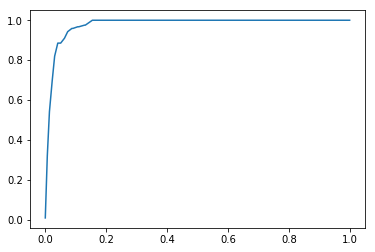

In [10]:
# and plot our ROC curve!
import matplotlib.pyplot as plt

# plot the false positive rate by true postive rate (aka recall)
plt.plot(roc.false_positive_rate, roc.recall)

## Step five: Use your model to predict outcomes

Now that you have evaluated your model, the next step is to use it to predict
outcomes. You use your model to predict the number of transactions made by
website visitors from each country. And you use it to predict purchases per user.

To run the query that uses the model to predict the number of transactions by country. (Note that you only need to SELECT the column you're grouping by, not every column you used in your prediction.)

In [11]:
%%bigquery
SELECT
  country,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY country
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

,country,total_predicted_purchases
0,United States,220
1,Taiwan,8
2,Canada,7
3,Turkey,2
4,Japan,2
5,India,2
6,Thailand,1
7,Guyana,1
8,Australia,1
9,Singapore,1


In the next example, you try to predict the number of transactions each website
visitor will make. This query is identical to the previous query except for the
`GROUP BY` clause. Here the `GROUP BY` clause &mdash; `GROUP BY fullVisitorId`
&mdash; is used to group the results by visitor ID.

To run the query that predicts purchases per user:

In [13]:
%%bigquery
SELECT
  fullVisitorId,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY fullVisitorId
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

,fullVisitorId,total_predicted_purchases
0,9417857471295131045,4
1,489038402765684003,2
2,7420300501523012460,2
3,2158257269735455737,2
4,2105122376016897629,2
5,806992249032686650,2
6,112288330928895942,2
7,0376394056092189113,2
8,1280993661204347450,2
9,8064625150033508396,2
